In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.preprocessing import sequence
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
%matplotlib inline

# Load glove vectors

In [3]:
import bcolz
import re
from numpy.random import normal
import _pickle as pickle

def load_vectors(loc):
    return (load_array(loc+'.dat'),
        pickle.load(open(loc+'_words.pkl','rb')),
        pickle.load(open(loc+'_idx.pkl','rb')))

def load_array(fname):
    return bcolz.open(fname)[:]

In [4]:
glove_vecs, glove_words, glove_wordidx = load_vectors('/data/glove/results/6B.300d')
glove_vec_len = len(glove_vecs[0])
glove_vecs = np.append(glove_vecs, np.zeros((1,glove_vec_len)), axis=0)
glove_words.append('####')
glove_wordidx['####'] = len(glove_words) - 1

# Import training data

In [5]:
import csv

raw_train_data = []
raw_train_labels = []

with open('/data/spooky_author/train_ascii.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for lid, text, author in reader:
        raw_train_data.append(text)
        raw_train_labels.append(author)

## Tokenize and transform training data

In [6]:
from nltk.tokenize import word_tokenize

tokenized_train_data = list(map(lambda x: word_tokenize(x.lower()), raw_train_data))

In [7]:
wordid_train_data = []

for sentence in tqdm(tokenized_train_data):
    wordid_train_data.append([])
    for word in sentence: 
        if word in glove_wordidx:
            wordid_train_data[-1].append(glove_wordidx[word])
        

100%|██████████| 19579/19579 [00:00<00:00, 62727.89it/s]


In [8]:
emptyidx = glove_wordidx['####']

In [9]:
line_lens = list(map(lambda x: len(x), wordid_train_data))

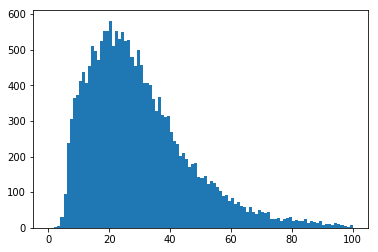

In [10]:
d = plt.hist(line_lens, bins=100, range=(0, 100))

In [11]:
max_len = 20

In [12]:
tdata = np.array([(([emptyidx]*max_len) + text)[-max_len:] for text in wordid_train_data])

In [13]:
tdata[1]

array([400000, 400000, 400000, 400000, 400000,     20,    332,    442,
         1858,      4,    285,     12,      0,  43888,    414,     30,
            7,   6575,   3895,      2])

In [14]:
glove_vecs.shape

(400001, 300)

# Transfrom labels

In [15]:
authors = sorted(list(set(raw_train_labels)))

In [16]:
author_indices = dict((a, i) for i, a in enumerate(authors))
indices_autor = dict((i, a) for i, a in enumerate(authors))

In [17]:
tlabels = to_categorical(list(map(lambda l: author_indices[l], raw_train_labels)))

In [18]:
number_of_classes = len(authors)

# Split data to train and validation

In [19]:
from sklearn.model_selection import train_test_split

train_data, valid_data, train_labels, valid_labels  = train_test_split(tdata, tlabels, test_size=0.05, shuffle=True)

In [20]:
print(train_data.shape, valid_data.shape, train_labels.shape, valid_labels.shape)

(18600, 20) (979, 20) (18600, 3) (979, 3)


# Create model

In [21]:
vocab_size = len(glove_words)

In [79]:
from keras.models import Sequential
from keras.layers import Embedding, GRU, Dense, Dropout, TimeDistributed,Bidirectional, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam

n_fac = 512 
bs = 2048
n_hidden=256

model=Sequential([
        Embedding(vocab_size, glove_vec_len, batch_input_shape=(None,max_len),weights=[glove_vecs], trainable=False),
        BatchNormalization(),
        Bidirectional(GRU(n_hidden,input_shape=(None,n_fac),return_sequences=True)),
        LeakyReLU(alpha=0.2),
        GRU(n_hidden, dropout=0.4, recurrent_dropout=0.1),
        Dense(1024, activation='relu'),
        Dropout(0.7),
        Dense(number_of_classes, activation='softmax')
    ])



ResourceExhaustedError: OOM when allocating tensor with shape[400001,300]
	 [[Node: embedding_13/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_13/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_13/embeddings, embedding_13/random_uniform)]]

Caused by op 'embedding_13/embeddings/Assign', defined at:
  File "/opt/conda/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/opt/conda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/opt/conda/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/opt/conda/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/opt/conda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/opt/conda/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-79-1111ffef4862>", line 18, in <module>
    Dense(number_of_classes, activation='softmax')
  File "/opt/conda/lib/python3.5/site-packages/keras/models.py", line 408, in __init__
    self.add(layer)
  File "/opt/conda/lib/python3.5/site-packages/keras/models.py", line 464, in add
    layer(x)
  File "/opt/conda/lib/python3.5/site-packages/keras/engine/topology.py", line 576, in __call__
    self.build(input_shapes[0])
  File "/opt/conda/lib/python3.5/site-packages/keras/layers/embeddings.py", line 101, in build
    dtype=self.dtype)
  File "/opt/conda/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 87, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.5/site-packages/keras/engine/topology.py", line 400, in add_weight
    constraint=constraint)
  File "/opt/conda/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 385, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/opt/conda/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/opt/conda/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 346, in _init_from_args
    validate_shape=validate_shape).op
  File "/opt/conda/lib/python3.5/site-packages/tensorflow/python/ops/state_ops.py", line 276, in assign
    validate_shape=validate_shape)
  File "/opt/conda/lib/python3.5/site-packages/tensorflow/python/ops/gen_state_ops.py", line 57, in assign
    use_locking=use_locking, name=name)
  File "/opt/conda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[400001,300]
	 [[Node: embedding_13/embeddings/Assign = Assign[T=DT_FLOAT, _class=["loc:@embedding_13/embeddings"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](embedding_13/embeddings, embedding_13/random_uniform)]]


In [23]:
opt = Nadam(lr=0.0007)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [24]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

In [25]:
model.fit(train_data, train_labels, validation_data=(valid_data, valid_labels), batch_size=bs, epochs=100,callbacks=[earlystop])

Train on 18600 samples, validate on 979 samples
Epoch 1/100
18600/18600 [==============================] - 2s 109us/step - loss: 1.0599 - acc: 0.4399 - val_loss: 0.9954 - val_acc: 0.4954
Epoch 2/100
18600/18600 [==============================] - 1s 35us/step - loss: 0.9761 - acc: 0.5270 - val_loss: 0.9222 - val_acc: 0.6016
Epoch 3/100
18600/18600 [==============================] - 1s 34us/step - loss: 0.9258 - acc: 0.5667 - val_loss: 0.8351 - val_acc: 0.6425
Epoch 4/100
18600/18600 [==============================] - 1s 35us/step - loss: 0.8205 - acc: 0.6359 - val_loss: 0.9510 - val_acc: 0.5577
Epoch 5/100
18600/18600 [==============================] - 1s 34us/step - loss: 0.8835 - acc: 0.6006 - val_loss: 0.7918 - val_acc: 0.6599
Epoch 6/100
18600/18600 [==============================] - 1s 35us/step - loss: 0.7730 - acc: 0.6670 - val_loss: 0.7670 - val_acc: 0.6670
Epoch 7/100
18600/18600 [==============================] - 1s 34us/step - loss: 0.7753 - acc: 0.6584 - val_loss: 0.7335 - v

In [ ]:
valid_preds = model.predict(valid_data)

In [ ]:
valid_preds

In [ ]:
idx = 5
print(valid_labels[idx])
print(valid_preds[idx])
print(' '.join([w for w in map(lambda x: glove_words[x], valid_data[idx]) if w != '####']))

In [ ]:
nevermore = np.zeros((1,80))

In [ ]:
nevermore[0,0] = glove_wordidx['nevermore']


In [ ]:
model.predict(nevermore)

In [ ]:
raw_train_data[0]
raw